**Melanoma Classification Assignment - Visalakshi**

**Problem Statement**
Build a CNN based model which can accurately detect melanoma. Melanoma is a  type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Approach**
1. Create the training, validation datasets using the data provided
2. Create Base CNN model with convolution and hidden layers and visualise the results.
3. Based on the results observed, improve the model performance to control overfitting/underfitting.
4. Create another model using techniques like Data Augmentation and/or Dropout.
5. Visualise the results of newly created model and see if problems seen in earlier model.
6. Check the class distribution and note the details of classes with highest and lowest number of data samples.
7. Add Data samples using Augmentor to overcome class imbalance problem seen.
8. Create training and validation data sets after creating data samples with Augmentor.
9. Create a model and fit the model using latest training and validation data sets.
10. Visualise the results and record the observations.

**Import required libraries**

In [292]:
import os
import pathlib
import zipfile
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Mount the drive**

In [293]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [294]:
from pathlib import Path
dataDir = "/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration"
dirpath = Path(dataDir)
print(dirpath)
if dirpath.exists() and dirpath.is_dir():
  print("Directory exists..Remove the directory and unzip the dataset files..")
  shutil.rmtree(dirpath)
else:
  print("Data Directory missing..Create the dataset now..")

/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration
Data Directory missing..Create the dataset now..


In [ ]:
#Create the dataset on the drive
!unzip '/content/gdrive/My Drive/CNN_assignment.zip'

Archive:  /content/gdrive/My Drive/CNN_assignment.zip
replace Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic ker

In [296]:
#Define path to train and test directories
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [297]:
#View the train and test image samples count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of training samples: ",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of test samples: ",image_count_test)

Number of training samples:  2239
Number of test samples:  118


**Load Data Using Keras Preprocessing**


**Create the Dataset**

In [298]:
#Define model parameters
batch_size = 32
num_classes = 9
epochs = 20
img_height = 180
img_width = 180

**Use 80% of data samples for training and 20% for validation. Create train and validation datasets accordingly.**

In [299]:
#Create training dataset using 80% of train data samples 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [300]:
#Create validation dataset using 20% of test data samples 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


**View the class names**

In [301]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Data Visualisation**

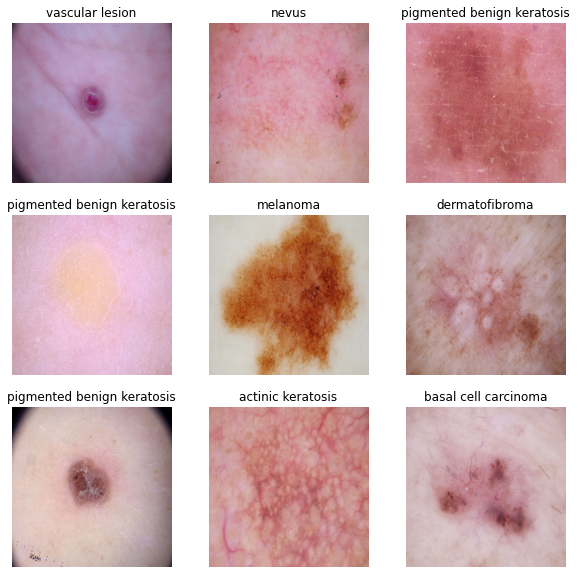

In [302]:
#View the images from each class
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [303]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


**Model Building and Evaluation**


**Configure the dataset for performance**

In [304]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardize the Data. The RGB channel values are in the [0, 255] range.Rescaling the data to normalize pixel values between (0,1)**

In [305]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [306]:
#View min and max sizes after rescaling
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0076793004 0.7911764


**Create the model**

In [307]:
#Create the base cnn model 
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])


Compile the model using Adam optimizer

In [308]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

View Model Summary statistics

In [309]:
model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_52 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 180, 180, 8)       224       
_________________________________________________________________
max_pooling2d_144 (MaxPoolin (None, 90, 90, 8)         0         
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 90, 90, 16)        1168      
_________________________________________________________________
max_pooling2d_145 (MaxPoolin (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_146 (MaxPoolin (None, 22, 22, 32)      

In [310]:
#Fit the model using 20 epochs
epochs=20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
56/56 [==============================] - 42s 747ms/step - loss: 2.1803 - accuracy: 0.2287 - val_loss: 1.7291 - val_accuracy: 0.3512
Epoch 2/20
56/56 [==============================] - 38s 676ms/step - loss: 1.7534 - accuracy: 0.3507 - val_loss: 1.5431 - val_accuracy: 0.4743
Epoch 3/20
56/56 [==============================] - 37s 663ms/step - loss: 1.5478 - accuracy: 0.4517 - val_loss: 1.4386 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 37s 662ms/step - loss: 1.4095 - accuracy: 0.5104 - val_loss: 1.4207 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 37s 659ms/step - loss: 1.3638 - accuracy: 0.5131 - val_loss: 1.4295 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 36s 650ms/step - loss: 1.2676 - accuracy: 0.5627 - val_loss: 1.3877 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 37s 656ms/step - loss: 1.1871 - accuracy: 0.5765 - val_loss: 1.3050 - val_accuracy: 0.5503

**Visualize the results**

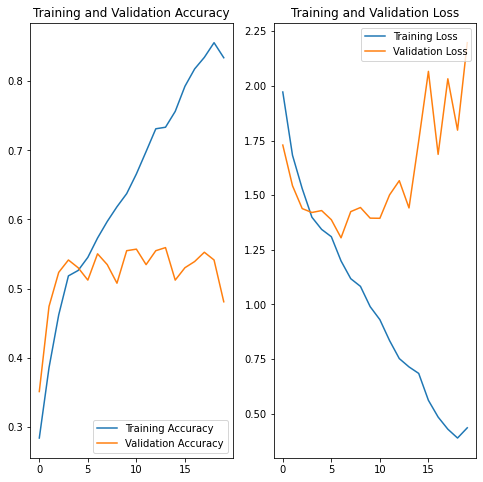

In [311]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Inferences**
 1. From above plots, we can see that training accuracy and validation accuracy are off by large margin and the model has achieved only around 50% accuracy on the validation set.
 2. In aobve plots, we can observe that training accuracy is increasing almost linearly over time whereas validation accuracy stalls between 50-60%.
 3. The difference in accuracy between training and validation accuracy is noticeable and we see a clear sign of **overfitting**.
 4. When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as **overfitting**. It means that the model will have a difficult time generalizing on a new dataset.
 
 **Let us work to reduce overfitting using techniques like 'data augmentation' ,'Dropout'**



**Data Augmentation**

Overfitting generally occurs when there are a small number of training examples. **Data augmentation** takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using the layers from tf.keras.layers.experimental.preprocessing. These can be included inside the model like other layers, and run on the GPU.

In [312]:
#perform data augmentation using Random Flip, Rotation and Zoom
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical", input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')])


**Visualize augmented data**

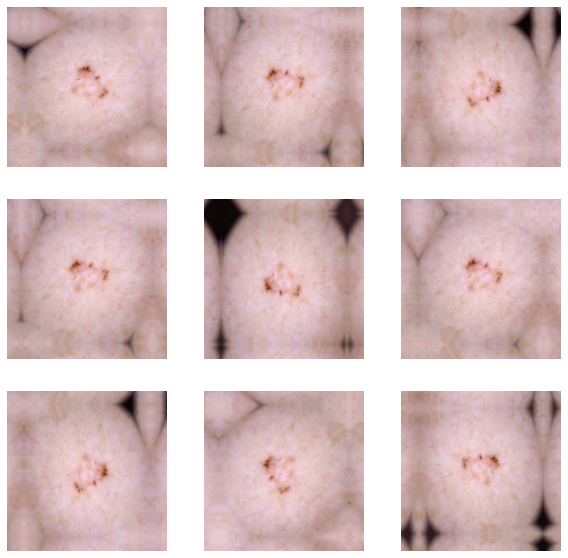

In [313]:
#Visualise the images after data augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Dropout**

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [314]:
#Create the model using data augmentation and dropout
from tensorflow.keras import regularizers

model_aug = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(512,activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

**Compile and train the model**

In [315]:
#Compile the model using 'adam' optimizer
optAdam=keras.optimizers.Adam(learning_rate=0.0003)
model_aug.compile(optimizer=optAdam,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [316]:
#View model summary statistics
print(model_aug.summary())

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_51 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_53 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 180, 180, 8)       224       
_________________________________________________________________
max_pooling2d_147 (MaxPoolin (None, 90, 90, 8)         0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 90, 90, 16)        1168      
_________________________________________________________________
max_pooling2d_148 (MaxPoolin (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 45, 45, 32)      

In [317]:
#Fit the model using 20 epochs
epochs = 20
history = model_aug.fit(train_ds,validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 47s 824ms/step - loss: 2.1067 - accuracy: 0.2238 - val_loss: 1.8277 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 46s 824ms/step - loss: 1.8255 - accuracy: 0.3341 - val_loss: 1.7155 - val_accuracy: 0.3691
Epoch 3/20
56/56 [==============================] - 46s 821ms/step - loss: 1.6951 - accuracy: 0.3860 - val_loss: 1.5761 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 46s 822ms/step - loss: 1.5678 - accuracy: 0.4490 - val_loss: 1.5789 - val_accuracy: 0.4564
Epoch 5/20
56/56 [==============================] - 46s 822ms/step - loss: 1.5328 - accuracy: 0.4541 - val_loss: 1.4674 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 46s 820ms/step - loss: 1.4736 - accuracy: 0.4852 - val_loss: 1.4422 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 52s 937ms/step - loss: 1.5060 - accuracy: 0.4835 - val_loss: 1.3956 - val_accuracy: 0.5257

**Visualize the results of using Data Augmentation and Dropout**

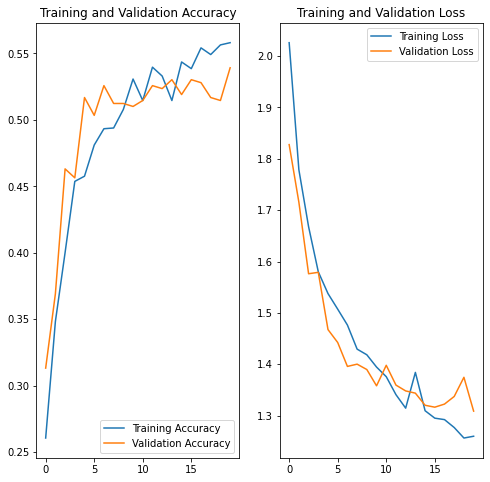

In [318]:
cc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Inferences** <BR>
1. From above plots, we can see reduced margin between training accuracy and validation accuracy.
2. In aobve plots, we can observe that training accuracy is increasing almost linearly over time.
3.The difference in accuracy between training and validation sets is noticeably decreased and issue of overfitting seems to be reduced now.
4. The model seems to be generalized now and this can be  further evaluated using large number of data samples and epochs.

**View Class distribution of data samples**

In [319]:
for i in os.listdir(data_dir_train):
  tmp=str(data_dir_train)+"/"+i
  each = os.listdir(tmp)
  print('Class ',i,' has ',len(each),' data samples')

Class  actinic keratosis  has  114  data samples
Class  basal cell carcinoma  has  376  data samples
Class  dermatofibroma  has  95  data samples
Class  melanoma  has  438  data samples
Class  nevus  has  357  data samples
Class  pigmented benign keratosis  has  462  data samples
Class  seborrheic keratosis  has  77  data samples
Class  squamous cell carcinoma  has  181  data samples
Class  vascular lesion  has  139  data samples


**1. Class 'pigmented benign keratosis' has 462(highest) data samples.**<BR>
**2. Class 'seborrheic keratosis' has 77(least) data samples.**

**Handle Class Imbalance**

#### python package known as `Augmentor` is used (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [320]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method

In [321]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
print(original_df)

                                                   Path  Label
0     /content/gdrive/My Drive/Skin cancer ISIC The ...  Train
1     /content/gdrive/My Drive/Skin cancer ISIC The ...  Train
2     /content/gdrive/My Drive/Skin cancer ISIC The ...  Train
3     /content/gdrive/My Drive/Skin cancer ISIC The ...  Train
4     /content/gdrive/My Drive/Skin cancer ISIC The ...  Train
...                                                 ...    ...
2234  /content/gdrive/My Drive/Skin cancer ISIC The ...  Train
2235  /content/gdrive/My Drive/Skin cancer ISIC The ...  Train
2236  /content/gdrive/My Drive/Skin cancer ISIC The ...  Train
2237  /content/gdrive/My Drive/Skin cancer ISIC The ...  Train
2238  /content/gdrive/My Drive/Skin cancer ISIC The ...  Train

[2239 rows x 2 columns]


In [322]:
#Creating Augmentor samples for all classes in training dataset
import Augmentor
path_to_dataset="/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F707A6B3790>: 100%|██████████| 500/500 [00:22<00:00, 22.64 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F707B311450>: 100%|██████████| 500/500 [00:21<00:00, 23.75 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F707B2B6390>: 100%|██████████| 500/500 [00:23<00:00, 20.96 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7F708666E1D0>: 100%|██████████| 500/500 [01:47<00:00,  4.63 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7087163C90>: 100%|██████████| 500/500 [01:34<00:00,  5.28 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7079F73DD0>: 100%|██████████| 500/500 [00:23<00:00, 21.59 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F708666E1D0>: 100%|██████████| 500/500 [00:53<00:00,  9.43 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7080FA5D90>: 100%|██████████| 500/500 [00:22<00:00, 21.86 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F707B014890>: 100%|██████████| 500/500 [00:23<00:00, 21.10 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [323]:
#View the count of images created using Augmentor
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [324]:
#Augmented images path list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(path_list_new)

['/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_4d6e2deb-8b66-40ee-87bd-d4074f81e5c5.jpg', '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_049f30de-7eb2-4baa-842b-785c608bff83.jpg', '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025957.jpg_f90c14c5-1f41-4759-bbf5-56dd7f964cec.jpg', '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_5d4aa1f2-631a-46d3-80e0-acf9137a7271.jpg', '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033456.jpg_9b11b60c-556

In [325]:
#Class list of Augmented images
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [326]:
#Create a dataframe using original and augmented images
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2) 
print(new_df)

                                                   Path            Label
0     /content/gdrive/My Drive/Skin cancer ISIC The ...            Train
1     /content/gdrive/My Drive/Skin cancer ISIC The ...            Train
2     /content/gdrive/My Drive/Skin cancer ISIC The ...            Train
3     /content/gdrive/My Drive/Skin cancer ISIC The ...            Train
4     /content/gdrive/My Drive/Skin cancer ISIC The ...            Train
...                                                 ...              ...
4495  /content/gdrive/My Drive/Skin cancer ISIC The ...  vascular lesion
4496  /content/gdrive/My Drive/Skin cancer ISIC The ...  vascular lesion
4497  /content/gdrive/My Drive/Skin cancer ISIC The ...  vascular lesion
4498  /content/gdrive/My Drive/Skin cancer ISIC The ...  vascular lesion
4499  /content/gdrive/My Drive/Skin cancer ISIC The ...  vascular lesion

[6739 rows x 2 columns]


In [327]:
#View the total image count
print(new_df['Label'].value_counts())

Train                         2239
seborrheic keratosis           500
basal cell carcinoma           500
squamous cell carcinoma        500
pigmented benign keratosis     500
dermatofibroma                 500
nevus                          500
vascular lesion                500
melanoma                       500
actinic keratosis              500
Name: Label, dtype: int64


**Train the model on the data created using Augmentor**

In [328]:
#Define the model parameters
batch_size = 32
img_height = 180
img_width = 180

In [329]:
#Create the training dataset using to hold augmented images along with original train data samples(80% of data samples)
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [330]:
#Create the validation dataset using to hold augmented images along with original train data samples(20% of total data)
val_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Create the model**

In [331]:
#Create the model to handle data imbalance now..
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(8, 3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(l=0.01)),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(16, 3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(l=0.01)),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, 3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(l=0.01)),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(512,activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [332]:
#Compile the model using lower learning rate of adam optimizer
optAdam=keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=optAdam, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [333]:
#View model summary statistics
model.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_51 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_54 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 180, 180, 8)       224       
_________________________________________________________________
max_pooling2d_150 (MaxPoolin (None, 90, 90, 8)         0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 90, 90, 16)        1168      
_________________________________________________________________
max_pooling2d_151 (MaxPoolin (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 45, 45, 32)      

In [334]:
#Fit the model with 30 epochs
epochs=30
history = model.fit(train_ds_aug, validation_data=val_ds_aug,epochs=epochs)

Epoch 1/30
169/169 [==============================] - 187s 1s/step - loss: 2.4742 - accuracy: 0.1368 - val_loss: 2.2017 - val_accuracy: 0.2175
Epoch 2/30
169/169 [==============================] - 191s 1s/step - loss: 2.1536 - accuracy: 0.2449 - val_loss: 2.0090 - val_accuracy: 0.2591
Epoch 3/30
169/169 [==============================] - 184s 1s/step - loss: 1.9714 - accuracy: 0.2719 - val_loss: 1.8188 - val_accuracy: 0.3133
Epoch 4/30
169/169 [==============================] - 182s 1s/step - loss: 1.8552 - accuracy: 0.2934 - val_loss: 1.7868 - val_accuracy: 0.3615
Epoch 5/30
169/169 [==============================] - 183s 1s/step - loss: 1.7561 - accuracy: 0.3423 - val_loss: 1.6866 - val_accuracy: 0.3816
Epoch 6/30
169/169 [==============================] - 183s 1s/step - loss: 1.6877 - accuracy: 0.3816 - val_loss: 1.5701 - val_accuracy: 0.4239
Epoch 7/30
169/169 [==============================] - 184s 1s/step - loss: 1.5873 - accuracy: 0.4166 - val_loss: 1.4670 - val_accuracy: 0.4640

**Visualise the results**

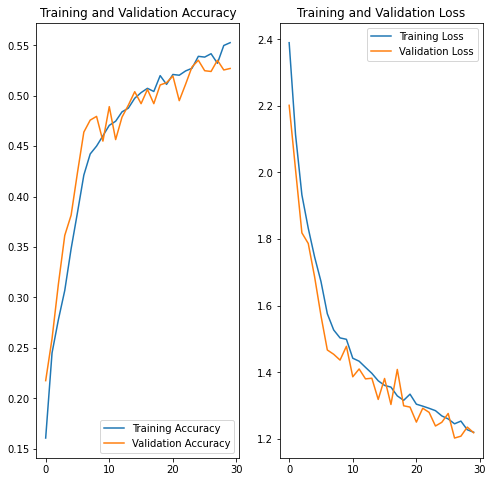

In [336]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Inferences**

1. From above plots, we can see further improvement in the performance w.r.t training accuracy and validation accuracy.
2. In above plots, we can observe that training accuracy is increasing over time and validation accuracy is close to training accuracy.
3.The difference in accuracy between training and validation sets is noticeably decreased.
4. The model is more genereralised now as per the results seen with large data and higher number of epochs. More improvement is seen with 50 epochs.

**Summary**

1. Deep Convolution Neural Networks are useful in the classification of Melanoma.
2. Deep learning architectures trained on large data sets can out perform Dermatologists in the dicease classification.
3. It is possible to tune the hyper parameters(number of filters,sizes,number of layers,learning rate etc..) and improve the performance of cnn network to assist doctors in diagnosis.
4. Problems like overfitting/underfitting can be controlled with hyper parameter tuning,regularisation and testing with large data samples.